# 3.1: Baseline GAN on MNIST

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("out_gan", exist_ok=True)

### Models

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.BatchNorm1d(512),
            nn.Linear(512, 784),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x.view(-1, 784)).squeeze(1)


Weights init

In [3]:
def weights_init_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

Dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_ds = datasets.MNIST("./data", train=True, download=True, transform=transform)
loader = DataLoader(train_ds, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 337kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.73MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.01MB/s]


### Init models + optim


In [5]:
z_dim = 100
G = Generator(z_dim).to(device)
D = Discriminator().to(device)
G.apply(weights_init_normal)
D.apply(weights_init_normal)

optG = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optD = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# Fixed noise for monitoring
fixed_noise = torch.randn(25, z_dim, device=device)


## Training loop : alongside progress tracking and outputting data

In [6]:
epochs = 20
G_losses, D_losses = [], []

for epoch in range(epochs):
    for real_imgs, _ in loader:
        bs = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        # ----------------- Train D -----------------
        optD.zero_grad()
        real_labels = torch.ones(bs, device=device)
        fake_labels = torch.zeros(bs, device=device)

        out_real = D(real_imgs)
        loss_real = criterion(out_real, real_labels)

        noise = torch.randn(bs, z_dim, device=device)
        fake_imgs = G(noise).detach()
        out_fake = D(fake_imgs)
        loss_fake = criterion(out_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optD.step()

        # ----------------- Train G -----------------
        optG.zero_grad()
        noise = torch.randn(bs, z_dim, device=device)
        fake_imgs = G(noise)
        out_fake = D(fake_imgs)
        loss_G = criterion(out_fake, real_labels)  # non-saturating trick
        loss_G.backward()
        optG.step()

        D_losses.append(loss_D.item())
        G_losses.append(loss_G.item())

    # Save samples each epoch
    with torch.no_grad():
        samples = G(fixed_noise).cpu()
    utils.save_image(samples, f"out_gan/epoch_{epoch+1:03d}.png", nrow=5, normalize=True, value_range=(-1,1))

    print(f"Epoch [{epoch+1}/{epochs}]  Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")



Epoch [1/20]  Loss D: 1.3914, Loss G: 1.1854
Epoch [2/20]  Loss D: 1.3468, Loss G: 1.0576
Epoch [3/20]  Loss D: 1.2414, Loss G: 0.8374
Epoch [4/20]  Loss D: 1.4047, Loss G: 0.6179
Epoch [5/20]  Loss D: 1.4096, Loss G: 0.6878
Epoch [6/20]  Loss D: 1.3936, Loss G: 0.7626
Epoch [7/20]  Loss D: 1.3721, Loss G: 0.7763
Epoch [8/20]  Loss D: 1.2986, Loss G: 0.8043
Epoch [9/20]  Loss D: 1.3606, Loss G: 1.0749
Epoch [10/20]  Loss D: 1.3343, Loss G: 0.7902
Epoch [11/20]  Loss D: 1.2832, Loss G: 0.8116
Epoch [12/20]  Loss D: 1.3777, Loss G: 0.8109
Epoch [13/20]  Loss D: 1.3129, Loss G: 0.8291
Epoch [14/20]  Loss D: 1.3835, Loss G: 0.8401
Epoch [15/20]  Loss D: 1.3051, Loss G: 0.6909
Epoch [16/20]  Loss D: 1.3718, Loss G: 0.8340
Epoch [17/20]  Loss D: 1.2598, Loss G: 0.7587
Epoch [18/20]  Loss D: 1.2222, Loss G: 0.7784
Epoch [19/20]  Loss D: 1.3512, Loss G: 0.9228
Epoch [20/20]  Loss D: 1.2242, Loss G: 0.8158


### Save loss curves


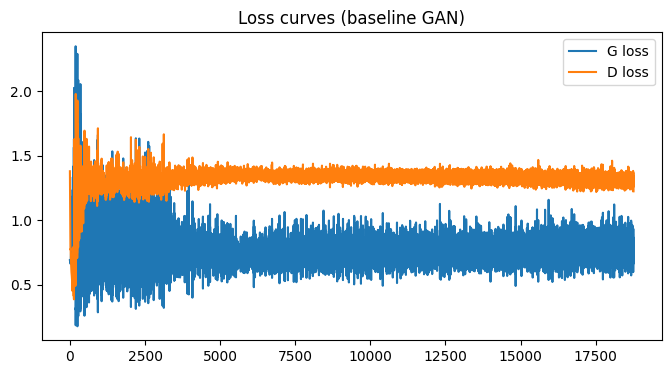

In [7]:

plt.figure(figsize=(8,4))
plt.plot(G_losses, label="G loss")
plt.plot(D_losses, label="D loss")
plt.legend()
plt.title("Loss curves (baseline GAN)")
plt.savefig("out_gan/losses.png", bbox_inches="tight")
plt.show()